# Swift transit model example I - basics

*Author:* Hannu Parviainen<br>
*Last modified:* 8.7.2020

The *swift* transit model (Parviainen, submitted 2020) implemented by ``pytransit.SwiftModel`` is a fast transit model that allows for any radially symmetric function to be used to model stellar limb darkening. The model offers flexibility with performance that is similar or superior to the analytical quadratic model by Mandel & Agol (2002) implemented by ``pytransit.QuadraticModel``.

The model follows the standard PyTransit API. The limb darkening model is given in the initialisation, and can be either the name of a set of built-in standard analytical limb darkening models

- ``constant``, ``linear``, ``quadratic``, ``nonlinear``, ``general``, ``power2``, and ``power2-pm``,

an instance of `pytransit.LDTkModel`, a Python callable that takes an array of $\mu$ values and a parameter vector, or a tuple with two callables where the first is the limb darkening model and the second a function returning the stellar surface brightness integrated over the stellar disk.

I demonstrate the use of custom limb darkening models and the LDTk-based limb darkening model (``pytransit.LDTkModel``) in the next notebooks, and here show basic examples of the *swift* model use with the named limb darkening models.

In [1]:
%pylab inline
rc('figure', figsize=(13,5))

Populating the interactive namespace from numpy and matplotlib


In [2]:
def plot_lc(time, flux, c=None, ylim=(0.9865, 1.0025), ax=None):
    if ax is None:
        fig, ax = subplots()
    else:
        fig, ax = None, ax
    ax.plot(time, flux, c=c)
    ax.autoscale(axis='x', tight=True)
    setp(ax, xlabel='Time [d]', ylabel='Flux', xlim=time[[0,-1]], ylim=ylim)
    
    if fig is not None:
        fig.tight_layout()
    return ax

## Import the model

In [3]:
from pytransit import SwiftModel

## Example 1: simple light curve

We begin with a simple light curve without any fancy stuff such as multipassband modeling. First, we create a time array centred around zero

In [4]:
time = linspace(-0.05, 0.05, 1500)

Next, we initialise and set up a ``SwiftModel`` choosing to use the four-parameter *nonlinear* limb darkening model and giving it the mid-exposure time array

In [5]:
tm = SwiftModel('nonlinear')
tm.set_data(time)

### Evaluation for scalar parameters

After the transit model has been initialised and the data set, we can evaluate the model for a given radius ratio (``k``), limb darkening ccoefficients (``ldc``), zero epoch (``t0``), orbital period (``p``), scaled semi-major axis ($a/R_\star$, ``a``), orbital inclination (``i``), eccentricity (``e``), and argument of periastron (``w``). Eccentricity and argument of periastron are optional and default to zero if not given.

The ``tm.evaluate`` method returns a 1D array with shape (``npt``) with the transit model evaluated for each mid-exposure time given in the ``time`` array.

**Note:** The first ``tm.set_data`` and ``tm.evaluate`` evaluation takes a significantly longer time than the succeeding calls to these methods. This is because most of the *PyTransit* routines are accelerated with *numba*, and *numba* takes some time compiling all the required methods.

In [6]:
flux1 = tm.evaluate(k=0.1, ldc=[0.36, 0.04, 0.1, 0.05], t0=0.0, p=1.0, a=4.2, i=0.5*pi, e=0.0, w=0.0)

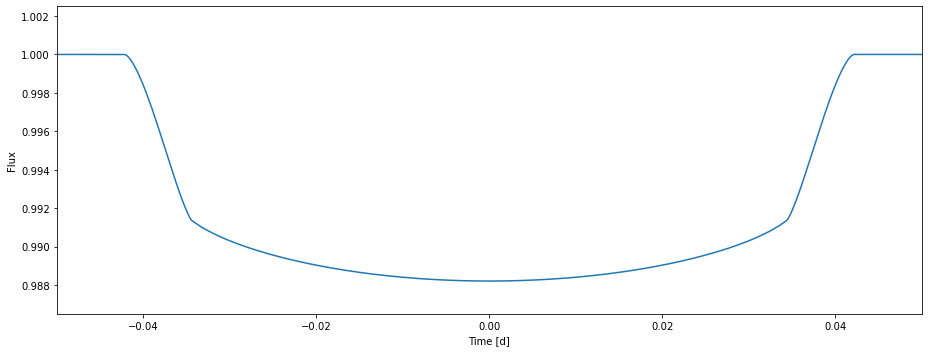

In [7]:
plot_lc(time, flux1);

### Evaluation for a set of parameters

Like the rest of the *PyTransit* transit models, the *swift* model can be evaluated simultaneously for a set of parameters. This is also done using *tm.evaluate*, but now each argument is a vector with ``npv`` values. Model evaluation is parallelised and can be significantly faster than looping over an parameter array in Python.

Now, the ``tm.evaluate`` returns a 2D array with shape ``[npv, npt]`` with the transit model evaluated for each parameter vector and mid-transit time given in the ``time`` array

In [8]:
npv = 5
ks    = normal(0.10, 0.002, (npv, 1))
t0s   = normal(0, 0.001, npv)
ps    = normal(1.0, 0.01, npv)
smas  = normal(4.2, 0.1, npv)
incs  = uniform(0.48*pi, 0.5*pi, npv)
es    = uniform(0, 0.25, size=npv)
os    = uniform(0, 2*pi, size=npv)
ldc   = uniform(0, 0.2, size=(npv,1,4))

In [9]:
flux2 = tm.evaluate(ks, ldc, t0s, ps, smas, incs, es, os)

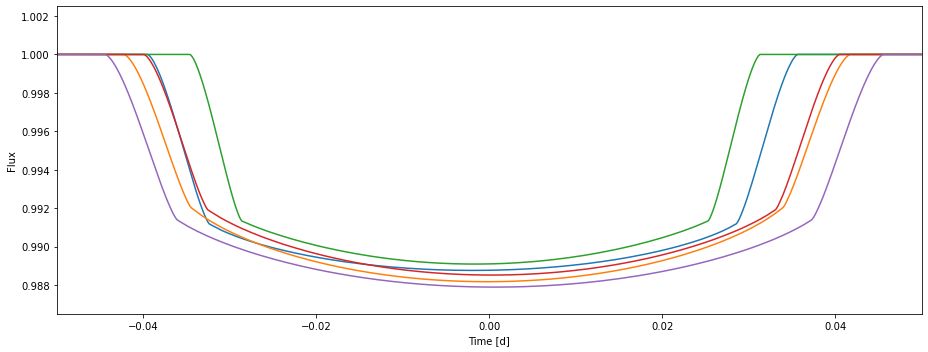

In [10]:
plot_lc(time, flux2.T);

### Supersampling

A single photometry observation is always an exposure over time. If the exposure time is short compared to the changes in the transit signal shape during the exposure, the observation can be modelled by evaluating the model at the mid-exposure time. However, if the exposure time is long, we need to simluate the integration by calculating the model average over the exposure time (although numerical integration is also a valid approach, it is slightly more demanding computationally and doesn't improve the accuracy significantly). This is achieved by supersampling the model, that is, evaluating the model at several locations inside the exposure and averaging the samples.

Evaluating the model many times for each observation naturally increases the computational burden of the model, but is necessary to model long-cadence observations from the *Kepler* and *TESS* telescopes.

All the transit models in PyTransit support supersampling. 

**GPU computing:** supersampling increases the computational burden of a single observation, what also leads to increasing advantage of using a GPU version of the transit model rather than a CPU version.

In [11]:
tm = SwiftModel('nonlinear')
tm.set_data(time, exptimes=0.02, nsamples=10)

In [12]:
flux3 = tm.evaluate(k=0.1, ldc=[0.36, 0.04, 0.1, 0.05], t0=0.0, p=1.0, a=4.2, i=0.5*pi, e=0.0, w=0.0)

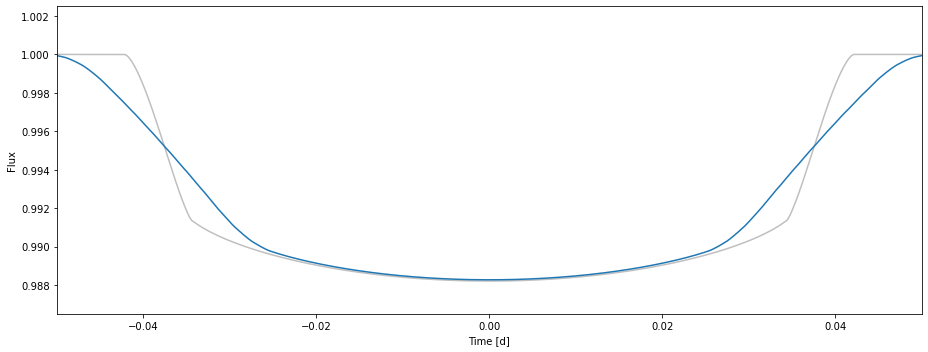

In [13]:
ax = plot_lc(time, flux1, c='0.75')
plot_lc(time, flux3, ax=ax);

## Example 2: heterogeneous light curve
### Multiple passbands

*PyTransit* aims to simplify modelling of heterogeneous light curves as much as possible. Here heterogeneous means that we can model light curves observed in different passbands, with different instruments, and with different supersampling requirements in one go. This is because most of the real exoplanet transit modelling science cases nowadays involve heterogeneous datasets, such as modelling long-cadence *Kepler* light curves together with short-cadence ground-based observations, or transmission spectroscopy where the light curves are created from a spectroscopic time series. 

To model heterogeneous light curves, *PyTransit* designates each observation (exposure, datapoint) to a specific light curve, and each light curve to a specific passband. This is done throught the light curve index array (``lcids``) and passband index array (``pbids``). Light curve index array is an integer array giving an index for each observed datapoints (suchs as, the indices for dataset of light curves would be either 0 or 1), while the passband index array is an integer array containing a passband index for each light curve in the dataset. So, a dataset of two light curves observed in a same passband would be

    times = [0, 1, 2, 3]
    lcids = [0, 0, 1, 1]
    pbids = [0, 0]
    
while a dataset containing two light curves observed in different passbands would be

    times = [0, 1, 2, 3]
    lcids = [0, 0, 1, 1]
    pbids = [0, 1]
    
Let's create two datasets. The first one divides our single light curve into two halves parts and gives each a different light curve index (0 for the first half and 1 for the second)

In [14]:
lcids1 = zeros(time.size, int)
lcids1[time.size//2:] = 1

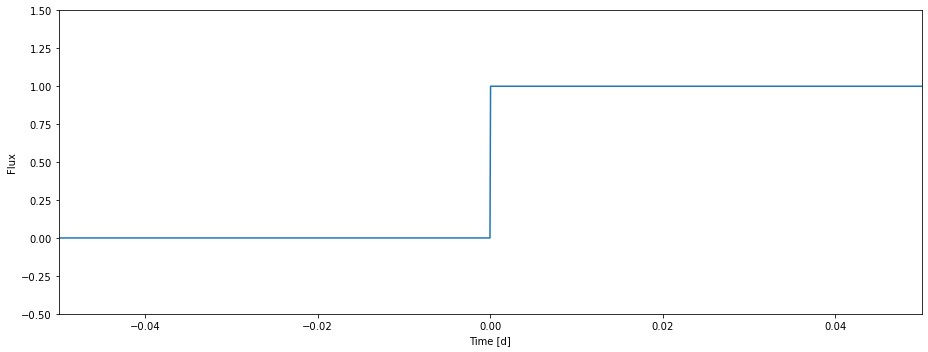

In [15]:
plot_lc(time, lcids1, ylim=(-0.5, 1.5));

The second dataset considers a more realistic scenario where we have three separate transits observed in two passbands. We create this by tiling our ``time`` array three times.

In [16]:
time2 = tile(time, 3)
lcids2 = repeat([0, 1, 1], time.size)

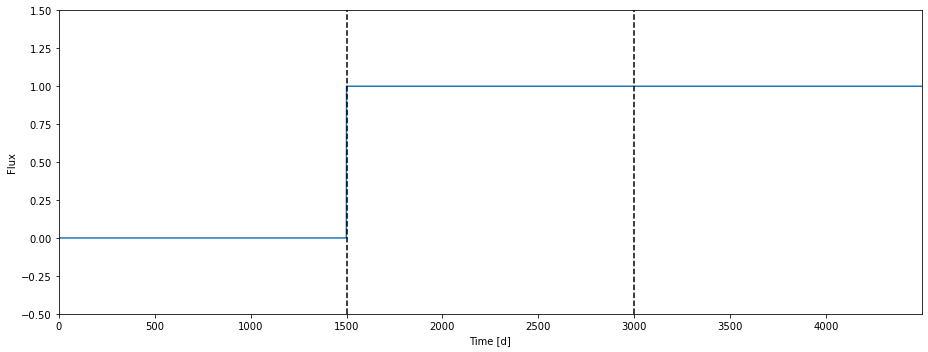

In [17]:
ax = plot_lc(arange(time2.size), lcids2, ylim=(-0.5, 1.5))
[ax.axvline(i*time.size, c='k', ls='--') for i in range(1,3)];

#### Achromatic radius ratio

Let's see how this works in practice. We divide our current light curve into two halves observed in different passbands. These passbands have different limb darkening, but we first assume that the radius ratio is achromatic.

In [18]:
tm = SwiftModel('power2')
tm.set_data(time, lcids=lcids1, pbids=[0, 1])

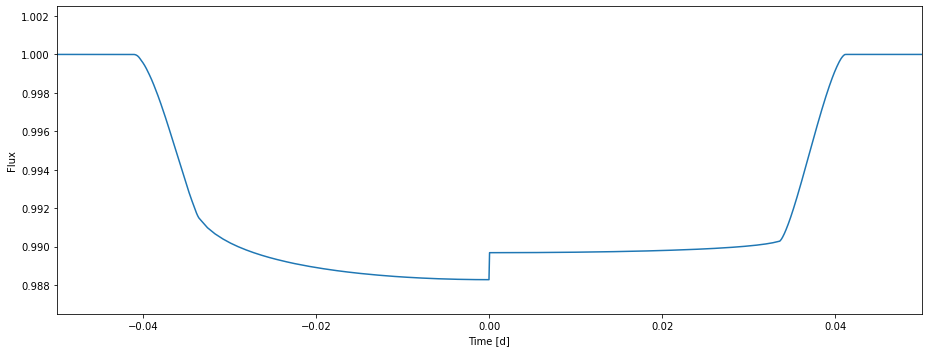

In [19]:
flux = tm.evaluate(k=0.1, ldc=[[3.1, 0.1],[2.1, 0.03]], t0=0.0, p=1.0, a=4.3, i=0.5*pi)
plot_lc(time, flux);

In [20]:
tm.set_data(time2, lcids=lcids2, pbids=[0, 1])

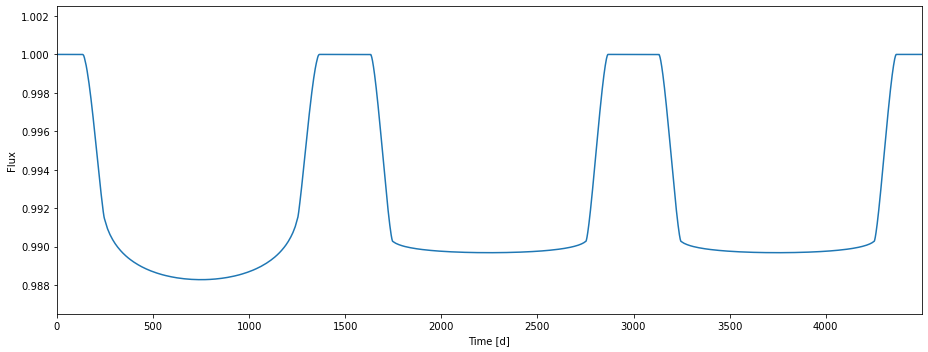

In [21]:
flux = tm.evaluate(k=0.1, ldc=[[3.1, 0.1],[2.1, 0.03]], t0=0.0, p=1.0, a=4.3, i=0.5*pi)
plot_lc(arange(flux.size), flux);

#### Chromatic radius ratio

Next, we assume that the radius ratio is chromatic, that is, it depends on the passband. This is achieved by giving the model an array of radius ratios (where the number should equal to the number of passbands) instead of giving it a scalar radius ratio.

In [22]:
tm.set_data(time, lcids=lcids1, pbids=[0, 1])

In [23]:
flux = tm.evaluate(k=[0.105, 0.08], ldc=[[3.1, 0.1],[2.1, 0.03]], t0=0.0, p=1.0, a=4.3, i=0.5*pi)

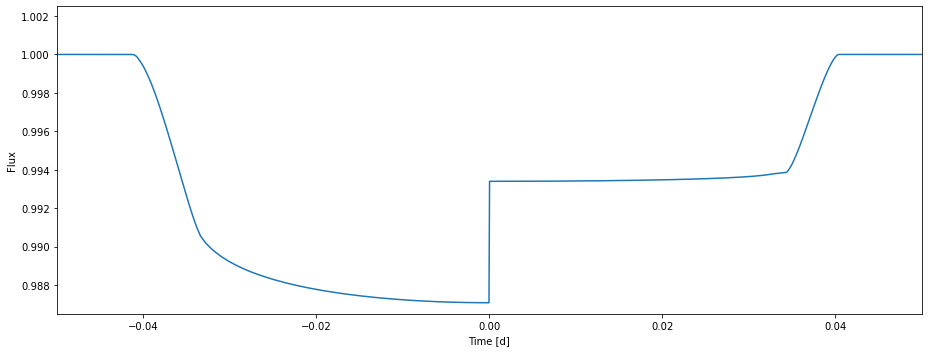

In [24]:
plot_lc(time, flux);

In [25]:
tm.set_data(time2, lcids=lcids2, pbids=[0, 1])

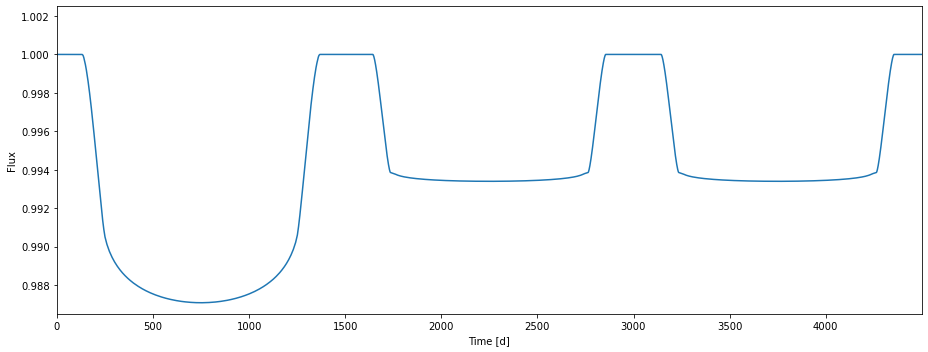

In [26]:
flux = tm.evaluate(k=[0.105, 0.08], ldc=[[3.1, 0.1],[2.1, 0.03]], t0=0.0, p=1.0, a=4.3, i=0.5*pi)
plot_lc(arange(flux.size), flux);

### Different superampling rates

Next, let's set different supersampling rates to the two light curves. There's no reason why we couldn't also let them have different passbands, but it's better to keep things simple at this stage.

In [27]:
tm.set_data(time, lcids=lcids1, exptimes=[0.0, 0.02], nsamples=[1, 10])

In [28]:
flux = tm.evaluate(k=0.105, ldc=[3.1, 0.1], t0=0.0, p=1.0, a=4.3, i=0.5*pi)

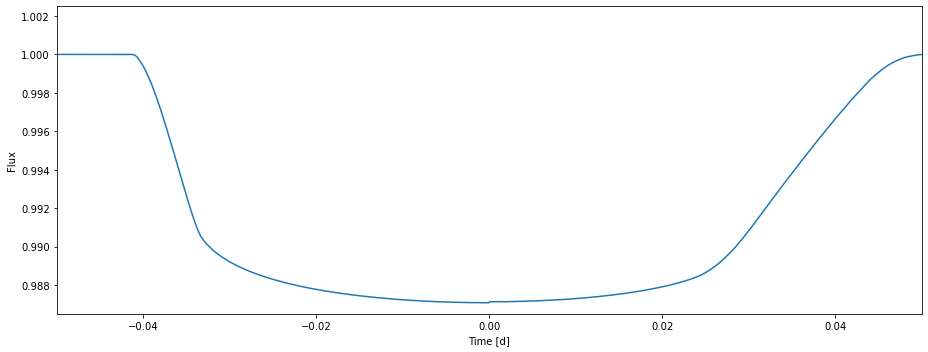

In [29]:
plot_lc(time, flux);

In [30]:
tm.set_data(time2, lcids=lcids2, exptimes=[0.0, 0.02], nsamples=[1, 10])

In [31]:
flux = tm.evaluate(k=0.105, ldc=[3.1, 0.1], t0=0.0, p=1.0, a=4.3, i=0.5*pi)

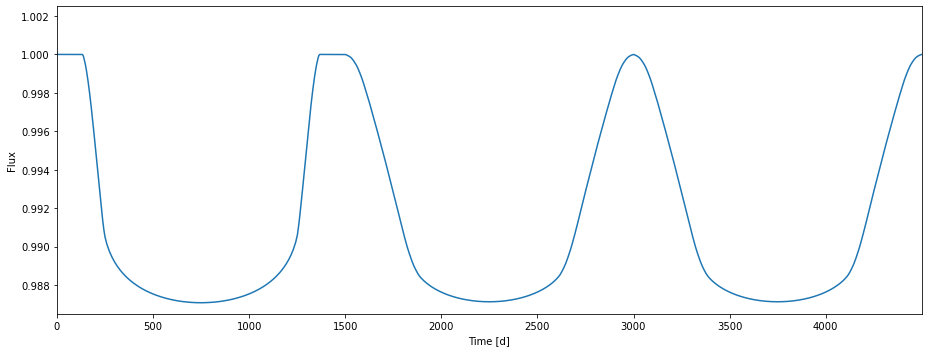

In [32]:
plot_lc(arange(flux.size), flux);

### Everything together

Finally, let's throw everything together and create a set of light curves observed in different passbands, requiring different supersampling rates, assuming chromatic radius ratios, for a set of parameter vectors.

In [34]:
tm = SwiftModel('quadratic-tri')
time3 = tile(time, 3)
lcids3 = repeat([0, 1, 2], time.size)
tm.set_data(time3, lcids=lcids3, pbids=[0, 1, 2], exptimes=[0.0, 0.02, 0.0], nsamples=[1, 10, 1])

In [35]:
npv = 5
ks    = uniform(0.09, 0.1, (npv, 3))
t0s   = normal(0, 0.002, npv)
ps    = normal(1.0, 0.01, npv)
smas  = normal(5.0, 0.1, npv)
incs  = uniform(0.48*pi, 0.5*pi, npv)
es    = uniform(0, 0.25, size=npv)
os    = uniform(0, 2*pi, size=npv)
ldc   = uniform(0, 0.5, size=(npv,3,2))

In [36]:
flux = tm.evaluate(k=ks, ldc=ldc, t0=t0s, p=ps, a=smas, i=incs, e=es, w=os)

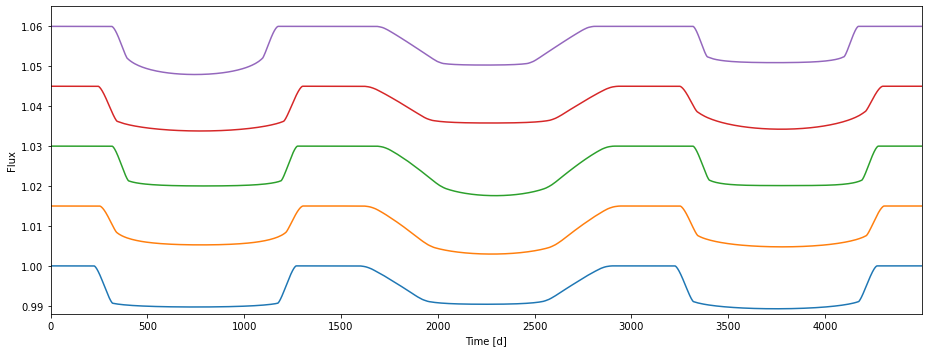

In [37]:
plot_lc(arange(flux.shape[1]), flux.T + linspace(0, 0.06, npv), ylim=(0.988, 1.065));

---

<center>©2020 Hannu Parviainen</center>